## Import

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Functions

In [2]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [11]:
# Create a transfer learning model from a URL
def create_transfer_learning_model(model_url, input_shape, num_classes=10, trainable=False):
  feature_extractor_layer = hub.KerasLayer(
    model_url,
    trainable=trainable,
    name='feature_extraction_layer',
    input_shape=input_shape
  )

  model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

## Download the Flowers Dataset from TFDS

In [3]:
(train_data, validation_data), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

class_names = np.array(dataset_info.features['label'].names)
num_classes = len(class_names)
num_train = len(train_data)
num_validation = len(validation_data)

print('Classes:', class_names)
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_train))
print('Total Number of Validation Images: {} \n'.format(num_validation))

Classes: ['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']
Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



## Reformat images and Create batches

In [14]:
BATCH_SIZE = 32
IMG_SHAPE = 299

def format_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))/255.0
  return image, label


train_batches = train_data.shuffle(num_train).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_data.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Transfer Learning

[tf2-preview/mobilenet_v2/classification](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4) (224, 224, 3)\
[tf2-preview/inception_v3/feature_vector](https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4) (299, 299, 3)\
[imagenet/mobilenet_v2_140_224/feature_vector](https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5) (224, 224, 3)\
[imagenet/mobilenet_v3_large_100_224/feature_vector](https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5) (224, 224, 3)

In [12]:
#URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
#URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5'
#URL = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5'

## Build the model

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = create_transfer_learning_model(URL, (IMG_SHAPE, IMG_SHAPE, 3), num_classes=len(class_names))

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_batches,
    epochs=5,
    validation_data=validation_batches
)

Epoch 1/5
81/81 [==============================] - 31s 323ms/step - loss: 0.7237 - accuracy: 0.7361 - val_loss: 0.4762 - val_accuracy: 0.8411
Epoch 2/5
81/81 [==============================] - 25s 315ms/step - loss: 0.3890 - accuracy: 0.8770 - val_loss: 0.3696 - val_accuracy: 0.8819
Epoch 3/5
81/81 [==============================] - 25s 312ms/step - loss: 0.3046 - accuracy: 0.9054 - val_loss: 0.3190 - val_accuracy: 0.8874
Epoch 4/5
81/81 [==============================] - 25s 312ms/step - loss: 0.2649 - accuracy: 0.9163 - val_loss: 0.3112 - val_accuracy: 0.8901
Epoch 5/5
81/81 [==============================] - 25s 313ms/step - loss: 0.2271 - accuracy: 0.9315 - val_loss: 0.2915 - val_accuracy: 0.8983


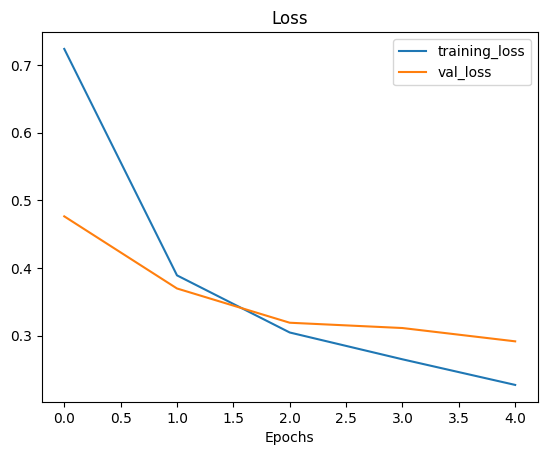

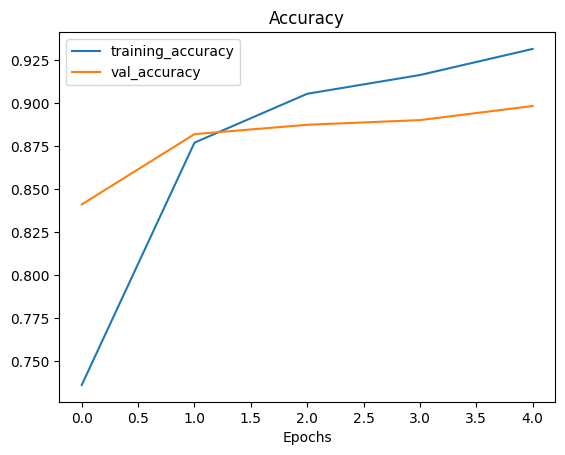

In [16]:
plot_loss_curves(history)